In [28]:
import pandas as pd
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
from pykalman import KalmanFilter
import time
import copy

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn import linear_model
from sklearn.metrics import r2_score
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [29]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ;

In [30]:
db = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Date'>

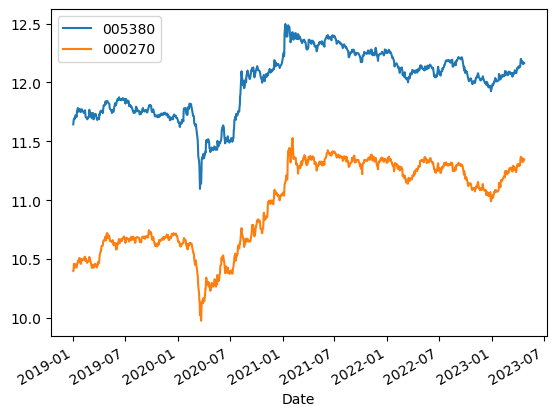

In [31]:
a0, a1 = '005380', '000270'
_to = '2023-04-24'

p = pd.concat([_s.loc[:_to, 'Close'] for _s in db], axis=1)
p.columns = univ

p_open = pd.concat([_s.loc[:_to, 'Open'] for _s in db], axis=1)
p_open.columns = univ

logp = np.log(p)

x = logp[a0]
y = logp[a1]
x.plot(legend=True)
y.plot(legend=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_15592\2125577369.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])


Text(0, 0.5, 'y')

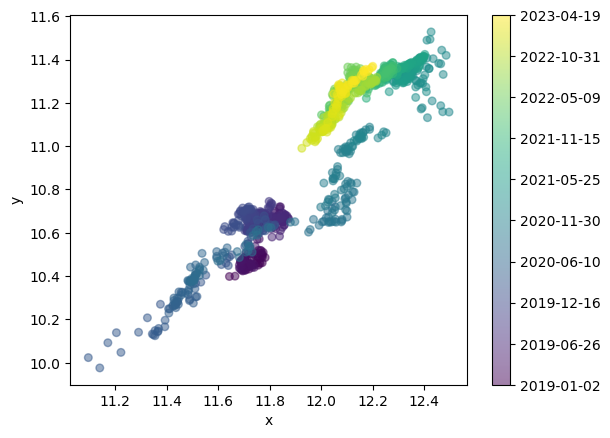

In [32]:
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, alpha=0.5)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('x')
plt.ylabel('y')

In [33]:
delta = 1e-2
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = sm.add_constant(x.values, prepend=False)[:, np.newaxis]

kf = KalmanFilter(n_dim_obs=1, 
                  n_dim_state=2, 
                  initial_state_mean=[1, 0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1,
                  transition_covariance=trans_cov)

state_means, state_covs = kf.filter(y.values)
beta = state_means[:,0]
alpha = state_means[:,1]

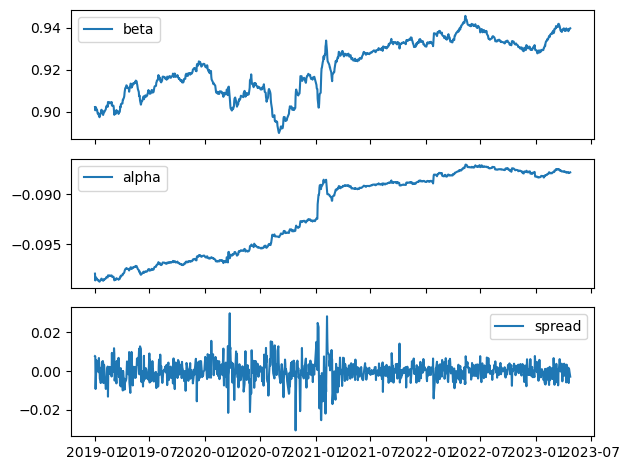

In [34]:
_, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x.index, beta, label='beta')
axarr[0].legend()

axarr[1].plot(x.index, alpha, label='alpha')
axarr[1].legend()

sp = beta*x - y + alpha
axarr[2].plot(x.index, sp, label='spread')
axarr[2].legend()

plt.tight_layout()

In [288]:
def _w(b):
    w0 = b / (abs(b) + 1)
    w1 = -np.sign(b) / (abs(b) + 1)
    w_max = max(abs(w0), abs(w1))
    return np.sign(w0 / w_max), np.sign(w1 / w_max)

def _get_weights(x, y, beta, alpha):
    trading = 'not'
    trading_start = 0
    w = np.zeros((len(beta), 2))

    for i in range(1, len(beta)):
        w[i] = w[i-1]

        if trading == 'not':
            _beta = beta[i]
            _alpha = alpha[i]

            signal = _beta * x + _alpha - y
            d_signal = signal[i] - signal[i-1]

            if signal[i] > 0 and d_signal < 0:
                trading = 'short'
                trading_start = signal[i]               
                w[i] = _w(-_beta)

            elif signal[i] < 0 and d_signal > 0:
                trading = 'long'
                trading_start = signal[i]
                w[i] = _w(_beta)

            else:
                w[i] = 0


        elif trading == 'long':
            if signal[i] < trading_start:
                trading = 'not'
                w[i] = 0

            if signal[i] > 0:
                trading = 'not'
                w[i] = 0

        elif trading == 'short':
            if signal[i] > trading_start:
                trading = 'not'
                w[i] = 0

            if signal[i] < 0:
                trading = 'not'
                w[i] = 0

    return w

In [35]:
class KalmanTrade:
    def __init__(self, stock0=None, stock1=None, date_from=None, date_to=None, db=None, kalman_delta=0.001, kalman_ocov=2):
        self.stock0 = stock0
        self.stock1 = stock1
        self.date_from = date_from
        self.date_to = date_to
        self.db = db
        self.kalman_delta = kalman_delta
        self.kalman_ocov = kalman_ocov
        self.start_cash = 1e8

        p = pd.concat([_s.loc[date_from:date_to, 'Close'] for _s in db], axis=1)
        p_open = pd.concat([_s.loc[date_from:date_to, 'Open'] for _s in db], axis=1)
        p.columns = p_open.columns = univ

        self.p = p[[stock0, stock1]]
        self.p_open = p_open[[stock0, stock1]]
        self.logp = np.log(p)
        self.x = self.logp[stock0]
        self.y = self.logp[stock1]
        
        self.kf = self.get_kalman()
        self.beta, self.alpha, self.state_covs = self.get_states()
        self.spread = self.beta * self.x - self.y + self.alpha
        
        # 백테스트 결과
        self.w = None
        self.shares = None
        self.cash = None
        self.pct_returns = None
        self.values = None
        self.pnl_hist = None
        self.pnl = None
        self.signal = None
        
        self.n_days = 0
        self.net_profit = 0
        self.net_return = 0
        self.cost = 0
        self.cost_rate = 0
        self.n_entry = 0
        self.n_entry_monthly = 0
        self.n_entry_days = 0
        self.n_holding_days = 0
        self.pnl_by_entry = 0
        self.profit_of_profit_entry = 0
        self.loss_of_loss_entry = 0
        self.hit_ratio = 0
        self.pnl_ratio = 0
        
        self.cagr = 0
        self.vol = 0
        self.rar = 0
        self.mdd = 0
        self.ctcy = 0
        
        
    def get_kalman(self):
        trans_cov = self.kalman_delta / (1 - self.kalman_delta) * np.eye(2)
        obs_mat = sm.add_constant(self.x.values, prepend=False)[:, np.newaxis]

        return KalmanFilter(n_dim_obs=1, 
                            n_dim_state=2, 
                            initial_state_mean=[1, 0],
                            initial_state_covariance=np.ones((2, 2)),
                            transition_matrices=np.eye(2),
                            observation_matrices=obs_mat,
                            observation_covariance=self.kalman_ocov,
                            transition_covariance=trans_cov)
    
    def get_states(self):
        state_means, state_covs = self.kf.filter(self.y.values)
        beta = state_means[:,0]
        alpha = state_means[:,1]
        return pd.Series(beta, index=self.x.index), pd.Series(alpha, index=self.x.index), state_covs
    
    def plot_spread(self):
        _, axarr = plt.subplots(3, sharex=True)
        axarr[0].plot(self.x.index, self.beta, label='beta')
        axarr[0].legend()

        axarr[1].plot(self.x.index, self.alpha, label='alpha')
        axarr[1].legend()

        #sp = self.beta * self.x - self.y + self.alpha
        axarr[2].plot(self.x.index, self.spread, label='spread')
        axarr[2].legend()

        plt.tight_layout()
        

    def plot_result(self):
        _, axarr = plt.subplots(4, sharex=True, gridspec_kw={'height_ratios': [4,2,2,1]})
        axarr[0].plot(self.x.index, self.pct_returns, label='cumulative')
        axarr[0].legend()

        mdd = self.values / np.maximum.accumulate(self.values) - 1
        axarr[1].plot(self.x.index, mdd, label='MDD')
        axarr[1].legend()
        
        z = self.signal.expanding().std()
        axarr[2].plot(self.x.index, self.signal)
        axarr[2].plot(self.x.index, self.spread)
        #axarr[2].plot(self.x.index, z)
        #axarr[2].plot(self.x.index, -z)
        
        axarr[3].plot(self.x.index, self.w)

        plt.tight_layout()
        
        
    def _w(self, b):
        w0 = b / (abs(b) + 1)
        w1 = -np.sign(b) / (abs(b) + 1)
        w_max = max(abs(w0), abs(w1))
        return np.sign(w0 / w_max), np.sign(w1 / w_max)
        #return w0 / w_max, w1 / w_max
            
    
    def get_weights(self, thres_entry=None):
        beta = self.beta.values
        alpha = self.alpha.values
        x = self.x.values
        y = self.y.values
        w = np.zeros((len(beta), 2))
        signal_spot = np.zeros(len(beta))
        
        trading = 'not'
        trading_start = 0
        leveraged = False
        
        for i in range(1, len(self.x)):
            w[i] = w[i-1]
            
            _beta = beta[i]
            _alpha = alpha[i]

            signal = _beta * x + _alpha - y
            d_signal = signal[i] - signal[i-1]
            signal_spot[i] = signal[i]
            z = signal_spot[:i].std()
            
            if trading == 'not':
#                 _beta = beta[i]
#                 _alpha = alpha[i]
                
#                 signal = _beta * x + _alpha - y
#                 d_signal = signal[i] - signal[i-1]
#                 signal_spot[i] = signal[i]
#                 z = signal_spot[:i].std()
                
#                 if signal[i] > 0 and d_signal < 0:
                if signal[i] > thres_entry * z:
                    trading = 'short'
                    trading_start = signal[i]               
                    w[i] = self._w(-_beta)

#                 elif signal[i] < 0 and d_signal > 0:
                elif signal[i] < -thres_entry * z:    
                    trading = 'long'
                    trading_start = signal[i]
                    w[i] = self._w(_beta)

                else:
                    w[i] = 0
                
            
            elif trading == 'long':
                signal_spot[i] = signal[i]
                
#                 if signal[i] < trading_start:
#                     trading = 'not'
#                     w[i] = 0

                if signal[i] < -1.5*z and not leveraged:
                    w[i] = w[i-1] * 2
                    leveraged = True

                if signal[i] > 0:
                    trading = 'not'
                    w[i] = 0
                    leveraged = False
            
            elif trading == 'short':
                signal_spot[i] = signal[i]
                
#                 if signal[i] > trading_start:
#                     trading = 'not'
#                     w[i] = 0

                if signal[i] > 1.5*z and not leveraged:
                    w[i] = w[i-1] * 2
                    leveraged = True

                if signal[i] < 0:
                    trading = 'not'
                    w[i] = 0
                    leveraged = False

        return w, signal_spot
            
        
    def get_consistency(self):
        #set_trace()
        y = np.log(self.values / self.values[0])
        X = np.arange(len(self.values)).reshape(-1, 1)
        model = linear_model.LinearRegression(fit_intercept=False).fit(X, y)
        return r2_score(y, model.predict(X))
    

    def backtest_loop(self, thres_entries=[]):
        return Validator(kalman_trader=self, thres_entries=thres_entries)
    
    def backtest(self, thres_entry=1, print_result=True):
        w, signal = self.get_weights(thres_entry=thres_entry)
        shares = np.zeros((len(self.p), 2))
        p = self.p.values
        p_open = self.p_open.values
        
        pnl = []
        cost = 0
        cash = np.zeros(len(self.x))
        values = np.zeros(len(self.x))
        pnl_hist = np.zeros(len(self.x))

        cash[0] = cash[1] = values[0] = values[1] = self.start_cash

        for t in range(2, len(self.x)):
            if np.any(w[t-1] != w[t-2]):
                target_shares = (self.start_cash * w[t-1] / p[t-1]).astype(int)

                shares[t] = target_shares
                cost0 = abs(shares[t, 0] - shares[t-1, 0]) * p_open[t, 0] * 0.00005
                cost1 = abs(shares[t, 1] - shares[t-1, 1]) * p_open[t, 1] * 0.00005
                cash[t] = cash[t-1] - ((shares[t] - shares[t-1]) * p_open[t]).sum() - cost0 - cost1
                cost += (cost0 + cost1)

#             if np.any(w[t] != w[t-1]):
#                 target_shares = (self.start_cash * w[t] / p[t]).astype(int)

#                 shares[t] = target_shares
#                 cost0 = abs(shares[t, 0] - shares[t-1, 0]) * p[t, 0] * 0.00005
#                 cost1 = abs(shares[t, 1] - shares[t-1, 1]) * p[t, 1] * 0.00005
#                 cash[t] = cash[t-1] - ((shares[t] - shares[t-1]) * p[t]).sum() - cost0 - cost1
#                 cost += (cost0 + cost1)

            else:
                shares[t] = shares[t-1]
                cash[t] = cash[t-1]

            values[t] = (shares[t] * p[t]).sum() + cash[t]

            if shares[t-1, 0] == 0 and shares[t, 0] != 0:
                pnl_hist[t] = values[t] - values[t-1]

            elif shares[t, 0] != 0 or (shares[t-1, 0] != 0 and shares[t, 0] == 0):
                pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]

            if shares[t-1, 0] != 0 and shares[t, 0] == 0:
                pnl.append(pnl_hist[t])

        self.w = pd.DataFrame(w, index=self.x.index, columns=[self.stock0, self.stock1])
        self.shares = pd.DataFrame(shares, index=self.x.index, columns=[self.stock0, self.stock1])
        self.cash = pd.Series(cash, index=self.x.index)
        self.values = pd.Series(values, index=self.x.index)
        self.pct_returns = (self.values - self.start_cash) / self.start_cash
        self.pnl_hist = pd.Series(pnl_hist, index=self.x.index)
        self.pnl = pd.Series(pnl)
        self.signal = pd.Series(signal, index=self.x.index)
        
        self.n_days = len(self.p)
        self.net_profit = int(values[-1] - self.start_cash)
        self.net_return = self.pct_returns[-1]
        self.cost = cost
        self.cost_rate = cost / (self.net_profit + cost)
        self.n_entry = len(pnl)
        self.n_entry_monthly = self.n_entry / self.n_days * 20
        self.n_entry_days = (w[:, 0] != 0).sum()
        self.n_holding_days = self.n_entry_days / self.n_entry
        self.pnl_by_entry = self.net_profit / self.n_entry
        #self.profit_of_profit_entry = self.pnl[self.pnl>0].mean()
        #self.loss_of_loss_entry = self.pnl[self.pnl<0].mean()
        self.hit_ratio = sum(self.pnl>0) / len(self.pnl)
        #self.pnl_ratio = -self.profit_of_profit_entry / self.loss_of_loss_entry
        
        self.cagr = (1 + self.net_return)**(250/self.n_days) - 1
        self.vol = self.values.pct_change().std() * (250**0.5)
        self.rar = self.cagr / self.vol
        self.mdd = (self.values / np.maximum.accumulate(self.values) - 1).min()
        self.ctcy = 0#self.get_consistency()

        if print_result:
            print(f'테스트 일수: {self.n_days}일')
            print(f'순손익 (투자금액대비%): {format(self.net_profit, ",")}원 ({self.net_return*100:.2f}%)')
            print(f'총비용 (총손익대비%): {format(int(self.cost), ",")}원 ({self.cost_rate*100:.2f}%)')
            print(f'진입횟수: {self.n_entry}회')
            print(f'월평균 진입횟수: {self.n_entry_monthly:.2f}회')
            print(f'진입일수 (전체일수대비%): {self.n_entry_days}일 ({self.n_entry_days/self.n_days*100:.2f}%)')
            print(f'평균보유일수: {self.n_holding_days:.2f}일')
            print(f'진입당 평균손익: {format(int(self.pnl_by_entry), ",")}원')
            print(f'최대수익: {format(int(max(pnl)), ",")}원')
            print(f'최대손실: {format(int(min(pnl)), ",")}원')
            #print(f'수익진입의 평균수익: {format(int(self.profit_of_profit_entry), ",")}원')
            #print(f'손실진입의 평균손실: {format(int(self.loss_of_loss_entry), ",")}원')
            print(f'승률: {self.hit_ratio*100:.2f}%')
            #print(f'손익비: {self.pnl_ratio:.2f}')
            print(f'CAGR: {self.cagr*100:.2f}%')
            print(f'변동성: {self.vol*100:.2f}%')
            print(f'위험조정수익률: {self.rar:.2f}')
            print(f'MDD: {self.mdd*100:.2f}%')
            print(f'수익안정성: {self.ctcy:.2f}')
            
        return self

In [36]:
class Validator:
    def __init__(self, kalman_trader=None, thres_entries=[]):
        self.kalman_trader = kalman_trader
        self.thres_entries = thres_entries
        self.results = [ copy.deepcopy(kalman_trader).backtest(thres_entry=te, print_result=False) for te in tqdm(thres_entries) ]

In [41]:
kt = KalmanTrade(stock0='005930', stock1='000660', date_from='2019-01-01', date_to='2023-04-27', db=db, kalman_delta=0.001, kalman_ocov=2)

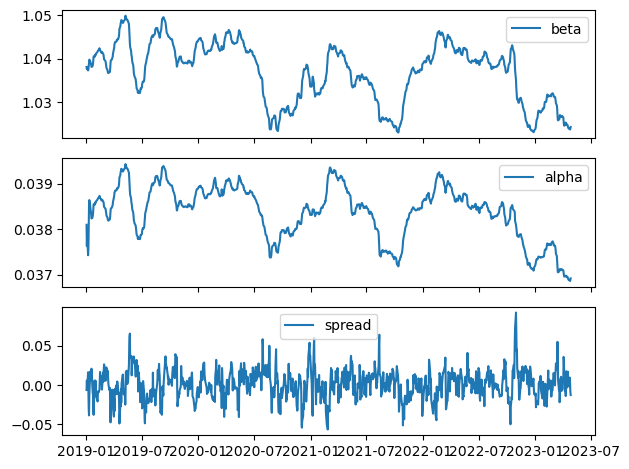

In [42]:
kt.plot_spread()

  0%|          | 0/30 [00:00<?, ?it/s]

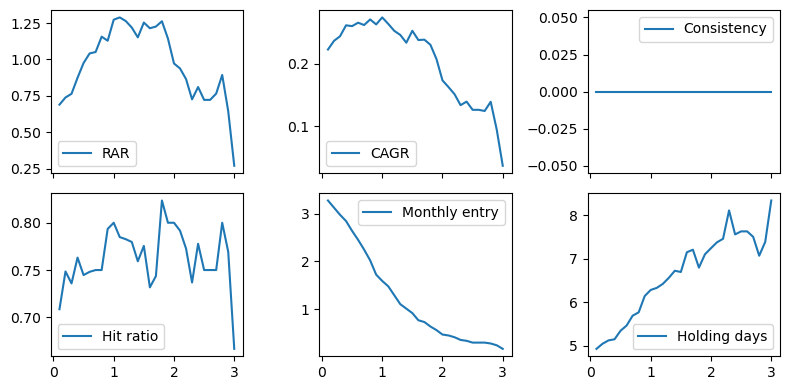

In [43]:
ktl = kt.backtest_loop(thres_entries=np.arange(0.1, 3.1, 0.1))

_, axarr = plt.subplots(2, 3, sharex=True, figsize=(8,4))
axarr[0,0].plot(ktl.thres_entries, [_r.rar for _r in ktl.results], label='RAR')
axarr[0,0].legend()

axarr[0,1].plot(ktl.thres_entries, [_r.cagr for _r in ktl.results], label='CAGR')
axarr[0,1].legend()

axarr[0,2].plot(ktl.thres_entries, [_r.ctcy for _r in ktl.results], label='Consistency')
axarr[0,2].legend()

axarr[1,0].plot(ktl.thres_entries, [_r.hit_ratio for _r in ktl.results], label='Hit ratio')
axarr[1,0].legend()

axarr[1,1].plot(ktl.thres_entries, [_r.n_entry_monthly for _r in ktl.results], label='Monthly entry')
axarr[1,1].legend()

axarr[1,2].plot(ktl.thres_entries, [_r.n_holding_days for _r in ktl.results], label='Holding days')
axarr[1,2].legend()

plt.tight_layout()

테스트 일수: 1069일
순손익 (투자금액대비%): 182,176,645원 (182.18%)
총비용 (총손익대비%): 2,407,504원 (1.30%)
진입횟수: 85회
월평균 진입횟수: 1.59회
진입일수 (전체일수대비%): 534일 (49.95%)
평균보유일수: 6.28일
진입당 평균손익: 2,143,254원
최대수익: 14,088,103원
최대손실: -25,417,646원
승률: 80.00%
CAGR: 27.46%
변동성: 21.57%
위험조정수익률: 1.27
MDD: -26.87%
수익안정성: 0.00


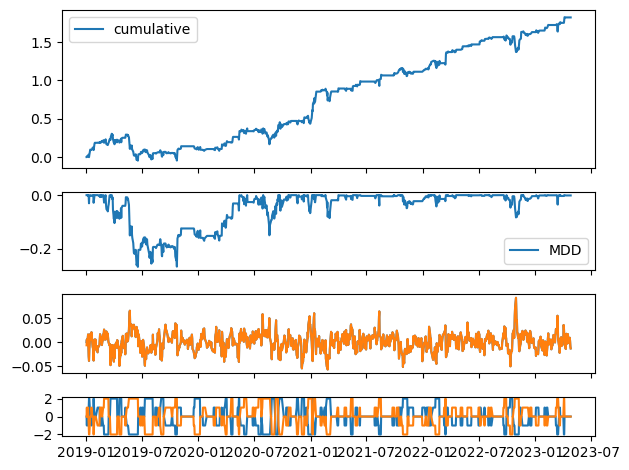

In [44]:
kt.backtest(thres_entry=1)
kt.plot_result()

테스트 일수: 1067일
순손익 (투자금액대비%): 182,176,645원 (182.18%)
총비용 (총손익대비%): 2,407,504원 (1.30%)
진입횟수: 85회
월평균 진입횟수: 1.59회
진입일수 (전체일수대비%): 534일 (50.05%)
평균보유일수: 6.28일
진입당 평균손익: 2,143,254원
최대수익: 14,088,103원
최대손실: -25,417,646원
승률: 80.00%
CAGR: 27.51%
변동성: 21.59%
위험조정수익률: 1.27
MDD: -26.87%
수익안정성: 0.00


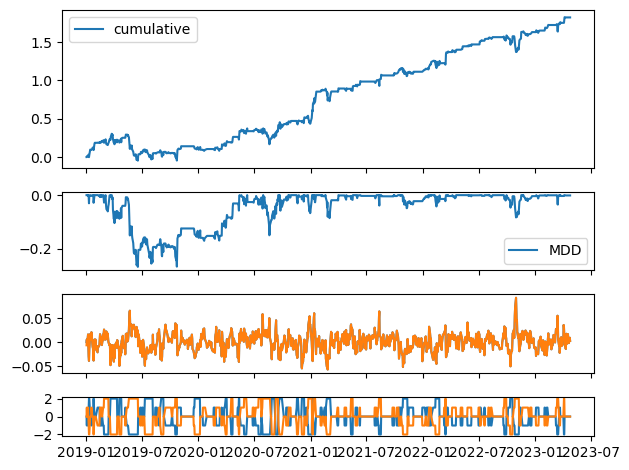

In [48]:
kt.backtest(thres_entry=1)
kt.plot_result()

In [45]:
kt.w

,005930,000660
Date,,
2019-01-02,0.0,0.0
2019-01-03,-1.0,1.0
2019-01-04,0.0,0.0
2019-01-07,-1.0,1.0
2019-01-08,0.0,0.0
...,...,...
2023-04-21,0.0,0.0
2023-04-24,0.0,0.0
2023-04-25,0.0,0.0


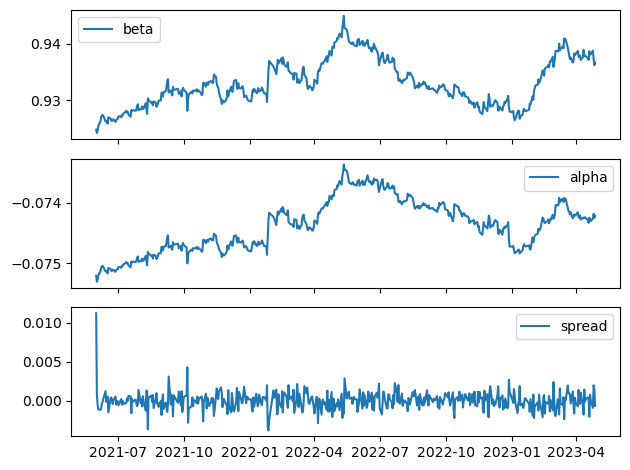

In [46]:
kt = KalmanTrade(stock0='005380', stock1='000270', date_from='2021-06-01', date_to='2023-04-27', db=db, kalman_delta=0.1, kalman_ocov=2)
kt.plot_spread()

  0%|          | 0/30 [00:00<?, ?it/s]

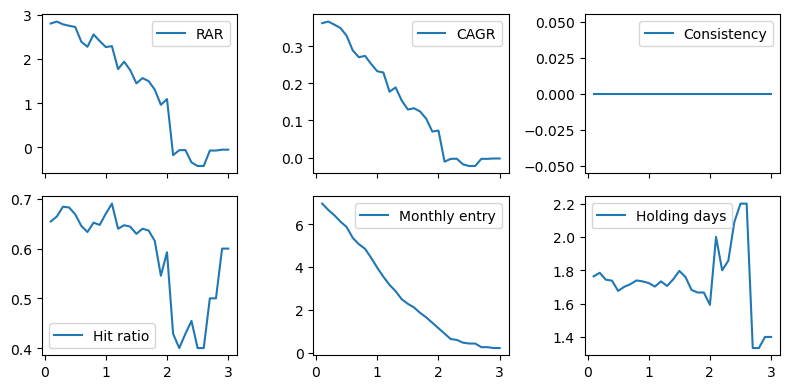

In [47]:
ktl = kt.backtest_loop(thres_entries=np.arange(0.1, 3.1, 0.1))

_, axarr = plt.subplots(2, 3, sharex=True, figsize=(8,4))
axarr[0,0].plot(ktl.thres_entries, [_r.rar for _r in ktl.results], label='RAR')
axarr[0,0].legend()

axarr[0,1].plot(ktl.thres_entries, [_r.cagr for _r in ktl.results], label='CAGR')
axarr[0,1].legend()

axarr[0,2].plot(ktl.thres_entries, [_r.ctcy for _r in ktl.results], label='Consistency')
axarr[0,2].legend()

axarr[1,0].plot(ktl.thres_entries, [_r.hit_ratio for _r in ktl.results], label='Hit ratio')
axarr[1,0].legend()

axarr[1,1].plot(ktl.thres_entries, [_r.n_entry_monthly for _r in ktl.results], label='Monthly entry')
axarr[1,1].legend()

axarr[1,2].plot(ktl.thres_entries, [_r.n_holding_days for _r in ktl.results], label='Holding days')
axarr[1,2].legend()

plt.tight_layout()

테스트 일수: 474일
순손익 (투자금액대비%): 71,353,437원 (71.35%)
총비용 (총손익대비%): 3,069,062원 (4.12%)
진입횟수: 139회
월평균 진입횟수: 5.86회
진입일수 (전체일수대비%): 233일 (49.16%)
평균보유일수: 1.68일
진입당 평균손익: 513,334원
최대수익: 4,614,298원
최대손실: -3,505,987원
승률: 66.91%
CAGR: 32.85%
변동성: 12.08%
위험조정수익률: 2.72
MDD: -4.31%
수익안정성: 0.00


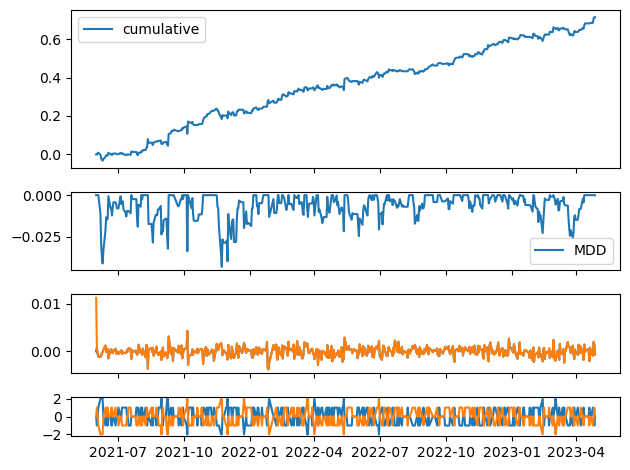

In [48]:
kt.backtest(thres_entry=0.5)
kt.plot_result()

테스트 일수: 473일
순손익 (투자금액대비%): 71,378,272원 (71.38%)
총비용 (총손익대비%): 3,059,027원 (4.11%)
진입횟수: 139회
월평균 진입횟수: 5.88회
진입일수 (전체일수대비%): 233일 (49.26%)
평균보유일수: 1.68일
진입당 평균손익: 513,512원
최대수익: 4,614,298원
최대손실: -3,505,987원
승률: 66.91%
CAGR: 32.94%
변동성: 12.10%
위험조정수익률: 2.72
MDD: -4.31%
수익안정성: 0.00


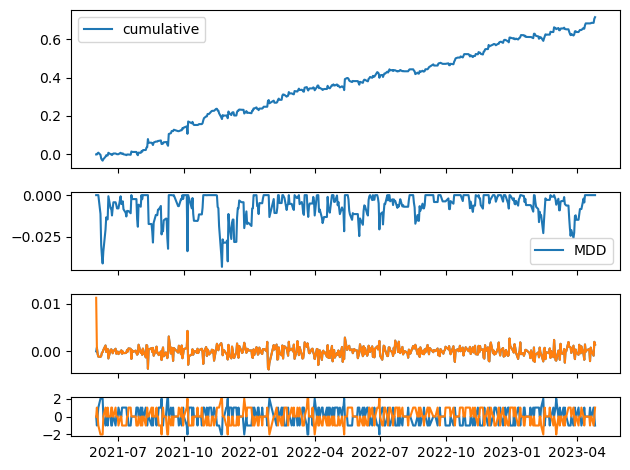

In [18]:
kt.backtest(thres_entry=0.5)
kt.plot_result()

<AxesSubplot:xlabel='Date'>

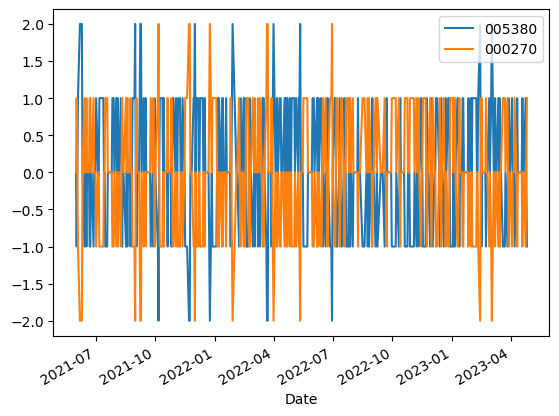

In [27]:
kt.w.plot()

In [51]:
kt.w

,005380,000270
Date,,
2021-06-01,0.0,0.0
2021-06-02,-1.0,1.0
2021-06-03,0.0,0.0
2021-06-04,1.0,-1.0
2021-06-07,2.0,-2.0
...,...,...
2023-04-21,0.0,0.0
2023-04-24,1.0,-1.0
2023-04-25,0.0,0.0


<AxesSubplot:xlabel='Date'>

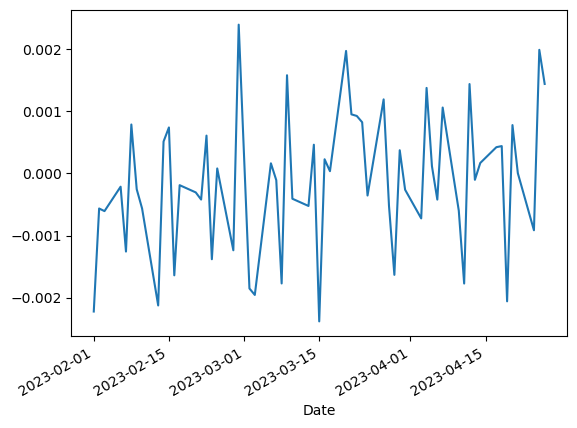

In [25]:
kt.signal.tail(60).plot()

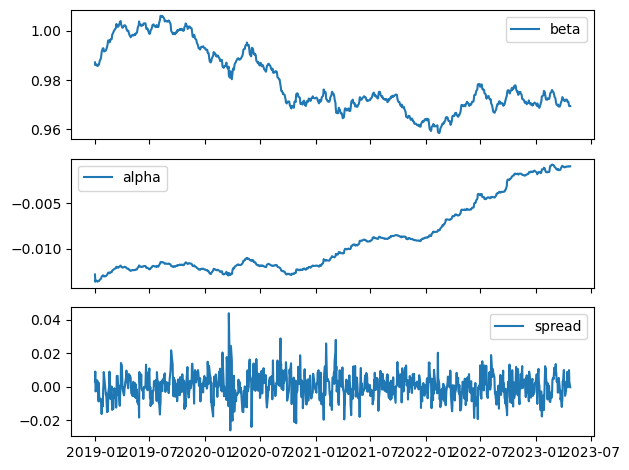

In [329]:
kt = KalmanTrade(stock0='105560', stock1='055550', date_to='2023-04-24', db=db, kalman_delta=0.01, kalman_ocov=3)
kt.plot_spread()

  0%|          | 0/30 [00:00<?, ?it/s]

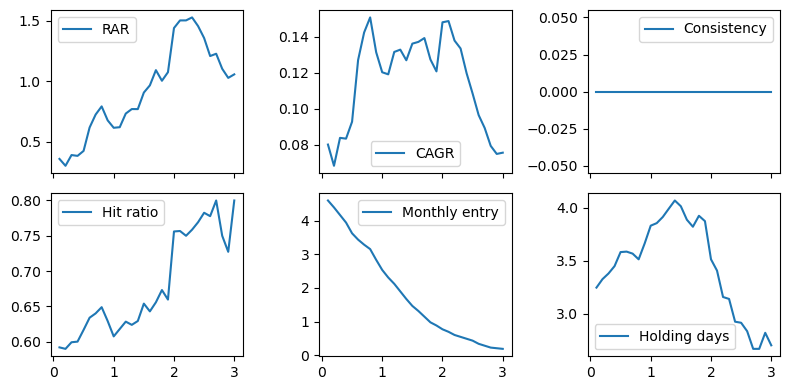

In [330]:
ktl = kt.backtest_loop(thres_entries=np.arange(0.1, 3.1, 0.1))

_, axarr = plt.subplots(2, 3, sharex=True, figsize=(8,4))
axarr[0,0].plot(ktl.thres_entries, [_r.rar for _r in ktl.results], label='RAR')
axarr[0,0].legend()

axarr[0,1].plot(ktl.thres_entries, [_r.cagr for _r in ktl.results], label='CAGR')
axarr[0,1].legend()

axarr[0,2].plot(ktl.thres_entries, [_r.ctcy for _r in ktl.results], label='Consistency')
axarr[0,2].legend()

axarr[1,0].plot(ktl.thres_entries, [_r.hit_ratio for _r in ktl.results], label='Hit ratio')
axarr[1,0].legend()

axarr[1,1].plot(ktl.thres_entries, [_r.n_entry_monthly for _r in ktl.results], label='Monthly entry')
axarr[1,1].legend()

axarr[1,2].plot(ktl.thres_entries, [_r.n_holding_days for _r in ktl.results], label='Holding days')
axarr[1,2].legend()

plt.tight_layout()

테스트 일수: 1066일
순손익 (투자금액대비%): 62,337,159원 (62.34%)
총비용 (총손익대비%): 3,785,440원 (5.72%)
진입횟수: 135회
월평균 진입횟수: 2.53회
진입일수 (전체일수대비%): 517일 (48.50%)
평균보유일수: 3.83일
진입당 평균손익: 461,756원
최대수익: 15,860,094원
최대손실: -12,212,380원
승률: 60.74%
CAGR: 12.03%
변동성: 19.53%
위험조정수익률: 0.62
MDD: -19.67%
수익안정성: 0.00


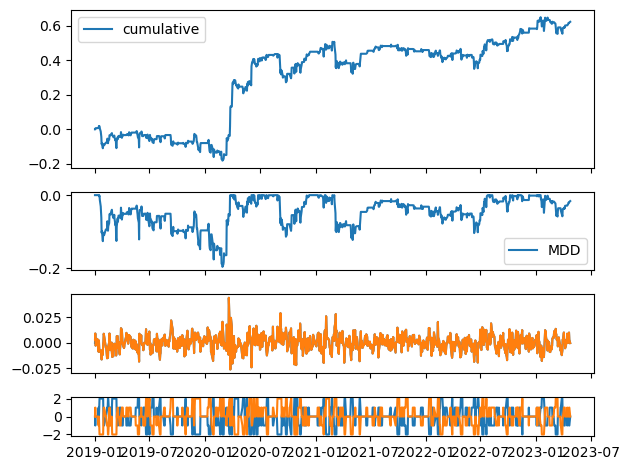

In [331]:
kt.backtest(thres_entry=1)
kt.plot_result()

In [314]:
kt.w

,105560,055550
Date,,
2019-01-02,0.0,0.0
2019-01-03,-1.0,1.0
2019-01-04,0.0,0.0
2019-01-07,0.0,0.0
2019-01-08,0.0,0.0
...,...,...
2023-04-18,0.0,0.0
2023-04-19,0.0,0.0
2023-04-20,0.0,0.0
